# Reproducing main results

This notebook reproduces the main results reported in for semi-supervised learning on the QM9 dataset.

In [7]:
%pip install -r requirements.txt
%pip install matplotlib==3.10.1

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 2.6, 2.6.1
ERROR: Ignored the following versions that require a different python version: 3.5 Requires-Python >=3.11; 3.5rc0 Requires-Python >=3.11; 3.6 Requires-Python >=3.11; 3.6rc0 Requires-Python >=3.11
ERROR: Could not find a version that satisfies the requirement networkx==3.5 (from versions: 0.34, 0.35, 0.35.1, 0.36, 0.37, 0.99, 1.0rc1, 1.0, 1.0.1, 1.1, 1.2rc1, 1.2, 1.3rc1, 1.3, 1.4rc1, 1.4, 1.5rc1, 1.5, 1.6rc1, 1.6, 1.7rc1, 1.7, 1.8rc1, 1.8, 1.8.1, 1.9rc1, 1.9, 1.9.1, 1.10rc2, 1.10, 1.11rc1, 1.11rc2, 1.11, 2.0, 2.1, 2.2rc1, 2.2, 2.3rc3, 2.3rc4, 2.3, 2.4rc1, 2.4rc2, 2.4, 2.5rc1, 2.5, 2.5.1, 2.6rc1, 2.6rc2, 2.6.2, 2.6.3, 2.7rc1, 2.7, 2.7.1, 2.8rc1, 2.8, 2.8.1rc1, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.8.5, 2.8.6, 2.8.7, 2.8.8, 3.0b1, 3.0rc1, 3.0, 3.1rc0, 3.1, 3.2rc0, 3.2, 3.2.1, 3.3rc0, 3.3, 3.4rc0, 3.4, 3.4.1, 3.4.2)
ERROR: No matching distribution found for networkx==3.5


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 49.9 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 27.3 MB/s  0:00:00

   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------------------------------- ------- 4/5 [matplotlib]
   -------------------------------- ------- 4/5 [matplotlib]
   -------------------------------- ------- 4/5 [matplotlib]
   -------------------------------- ------- 4/5 [matplotlib]
   -------------------------------- ------- 4/5 [mat

In [8]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf

sys.path.append(os.path.join(os.getcwd(), "src"))

from src.models import DimeNetPPModel 
from src.qm9 import QM9DataModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

c:\Users\morte\miniconda3\envs\DL-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cuda


In [9]:
MODEL_PATH = "model.pt" 

if not os.path.exists(MODEL_PATH):
    print(f"Error: Could not find model at {MODEL_PATH}")
else:
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    print("Checkpoint loaded successfully.")
    print("Keys available:", checkpoint.keys())
    
    data_mean = checkpoint["data_mean"].to(device)
    data_std = checkpoint["data_std"].to(device)
    print(f"Data Mean: {data_mean.item():.4f}, Data Std: {data_std.item():.4f}")

Checkpoint loaded successfully.
Keys available: dict_keys(['state_dict', 'model_config', 'data_mean', 'data_std'])
Data Mean: -6.5378, Data Std: 0.6049


In [10]:
model_config = checkpoint["model_config"]

model_config.pop("_target_", None)
model_config.pop("_partial_", None)

print(f"Initializing model with config: {model_config}")

model = DimeNetPPModel(**model_config)

model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

print("Model successfully loaded and moved to device.")

Initializing model with config: {'num_node_features': 11, 'hidden_channels': 128, 'out_channels': 1, 'num_blocks': 4, 'int_emb_size': 64, 'basis_emb_size': 8, 'out_emb_channels': 64, 'num_spherical': 7, 'num_radial': 6, 'cutoff': 5.0, 'max_num_neighbors': 32, 'num_before_skip': 1, 'num_after_skip': 2, 'num_output_layers': 3, 'act': 'swish', 'output_initializer': 'zeros', 'pretrained': True}
Model successfully loaded and moved to device.


In [11]:
TARGET_IDX = 2 

dm = QM9DataModule(
    target=TARGET_IDX,
    data_dir="./data",  
    batch_size_inference=128,
    num_workers=0,      
    seed=0             
)

dm.prepare_data()
dm.setup()

test_loader = dm.test_dataloader()
print(f"Test loader ready with {len(test_loader.dataset)} samples.")

Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Test loader ready with 13084 samples.


In [12]:
all_preds = []
all_targets = []

print("Running inference on Test Set...")

with torch.no_grad():
    for batch_data in tqdm(test_loader):
        if isinstance(batch_data, (tuple, list)):
            batch, targets = batch_data
        else:
            batch = batch_data
            targets = batch.y

        batch = batch.to(device)
        
        pred_norm = model(batch)
        
        pred_real = (pred_norm * data_std) + data_mean
        
        all_preds.append(pred_real.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds).numpy().flatten()
all_targets = torch.cat(all_targets).numpy().flatten()

mae = np.mean(np.abs(all_preds - all_targets))
mse = np.mean((all_preds - all_targets)**2)

print("="*30)
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test MSE: {mse:.4f}")
print("="*30)

Running inference on Test Set...


100%|██████████| 103/103 [00:08<00:00, 11.59it/s]

Final Test MAE: 0.0775
Final Test MSE: 0.0133


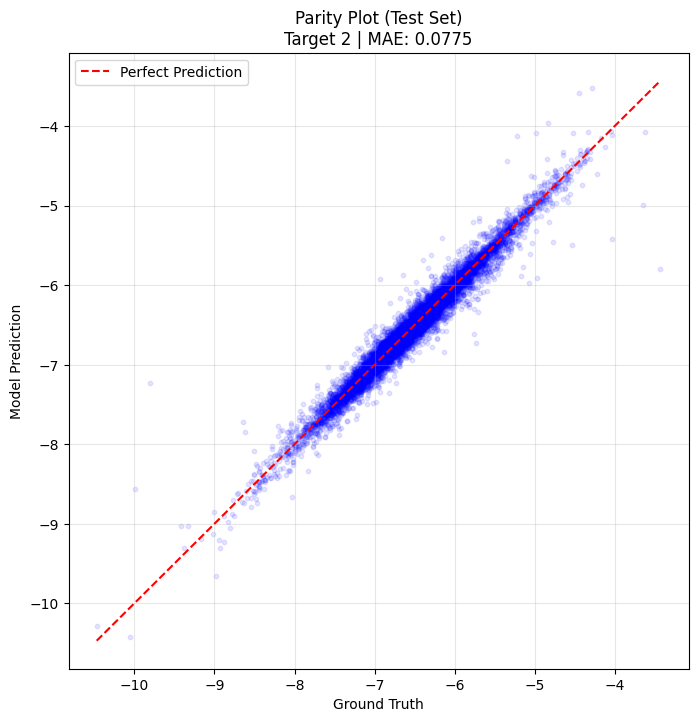

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_preds, alpha=0.1, s=10, color='blue')

min_val = min(all_targets.min(), all_preds.min())
max_val = max(all_targets.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title(f"Parity Plot (Test Set)\nTarget {TARGET_IDX} | MAE: {mae:.4f}")
plt.xlabel("Ground Truth")
plt.ylabel("Model Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()